# Please install the following python libraries
- python3: https://www.python.org/
- numpy: https://numpy.org/install/
- tqdm: https://github.com/tqdm/tqdm#installation
- matplotlib: https://matplotlib.org/stable/users/installing/index.html
- pygame: https://www.pygame.org/wiki/GettingStarted
- ipywidgets: https://ipywidgets.readthedocs.io/en/latest/user_install.html

If you encounter the error: "IProgress not found. Please update jupyter & ipywidgets"
    
Please install the ipywidgets as follows:

    with pip, do
    - pip install ipywidgets
    
    with conda, do
    - conda install -c conda-forge ipywidgets
    
Restart your notebook 

## Implement Deep Neural Networks using Pytorch.

In this exercise, we will use the Pytorch library (https://pytorch.org/) to build and train our deep neural networks. In the deep learning literature, especially in the research community, Pytorch is SUPER popular due to its automatic differentiation and dynamic computational graph (i.e., the graph is automatically generated, which is different from tensorflow where you have to define them beforehand). Briefly spearking, using Pytorch, you only have to build your neural network, define the forward pass, and the loss function. The library will automatically compute the weights and perform the backpropagation for you. For more details about Pytorch, we recommend you check the tutorails on the offical website to learn the basics (https://pyorg/tutorials/). If you come across any errors with training, try restarting the kernel first. 

Please try to learn the basics as much as you can. If you have any questions, feel free to ask them on Piazza or TA hours. 

Tested on Python 3.11.5

## Please install the Pytorch library on your computer before you run this notebook.

The installation instructions can be found here. (https://pyorg/get-started/locally/)

In [17]:

import random
from collections import namedtuple
import copy
import gymnasium as gym
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import tqdm
import math
import torch.nn.functional as F


# Q1: Nonlinear Function Approximation with Neural Networks

We design this question to help you get familiar with the basics in the Pytorch library. Please read the question carefully in the problem set because we will focus more on Pytorch implementation here.

### Preparing the training set

First, we create a training set to train the neural network model. Specifically, the dataset contains N training samples. For each sample, it is represented as (x, y), where x is input to the non-linear function "f(x) = 1 + x^2" and y is the output value. 

We provide a scaffolding code below to generate a training set that contains N samples for a particular non-linear function. Please complete the function below

In [18]:
""" Function is used to create a dataset that contains "num" samples given a particular non-linear function.
    In this case, the non-linear function is f(x) = 1 + x ^ 2.
""" 
def create_dataset(num, start_val, env_val):
    """ Function that generates a dataset 
        
        Args:
            num (int): number of samples to generate
            start_val (float): the minimal value of x (included)
            end_val (float): the maximal value of x (included)
    
        Returns:
            dataset (list): a list consists of (x, y) pairs.
    """
    def nonlinear_function(val):
        """ CODE HERE: non-linear function: 1 + val ^ 2
        """
        return 1 + val ** 2

    """ CODE HERE: 
        - create "num" even values between start_val and end_val using numpy.linspace
        - create the dataset, which is a list of training tuples. e.g. (x, y)
    """
    dataset = []
    x_vals = np.linspace(start_val, env_val, num)
    for x in x_vals:
        y = nonlinear_function(x)
        dataset.append((x, y))

    return dataset

### Construct the neural network using Pytorch

Here, we will define a Neural Network using the Pytorch library. 

In [ ]:
""" Normally, using Pytorch, we will implement the Neural Network as a class.

    Basically, we have to do the following steps:
        - Inherit from the torch.nn.Module that contains the basics of Neural Networks in Pytorch.
        - Define the architecture of the Neural Network in the "def __init__() function"
            e.g., you can find the functions to create layers with different types under torch.nn. 
                  for example, we can build one linear layer use torch.nn.Linear() as follows. 
        - Define how you would like to perform a forward propagation using you neural network in the 
          "def forward()""
"""
class NeuralNet(nn.Module):
    def __init__(self, num_hidden_layer, dim_hidden_layer):
        """ Args:
                num_hidden_layer (int): number of the hidden layers
                dim_hidden_layer (int): dimension for each hidden layer. You can use different dimensions for
                                        different layers. But, we use the same dimension for all hidden layers
                                        just for simplicity. 
                                        
            In this exercise, you are asked to design a 4-layers (2 hidden layers) fully connected neural network.
        """
        super(NeuralNet, self).__init__()
        
        # define the input dimension
        self.input_dim = 1

        # define the hidden dimension
        self.hidden_num = num_hidden_layer

        # define the number of the hidden layers
        self.hidden_dim = dim_hidden_layer

        # define the output dimension
        self.output_dim = 1

        """ CODE HERE:
            Create a fully connected neural network here
        """
        # define the input linear layer here
        self.input_layer = nn.Linear(self.input_dim, self.hidden_dim)
        
        # define the activation function here
        self.relu = nn.ReLU()
        
        # define the first hidden layer here
        self.hidden_layer1 = nn.Linear(self.hidden_dim, self.hidden_dim)
        
        # define the second hidden layer here
        self.hidden_layer2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        
        # define the output layer here
        self.output_layer = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, x):
        """ Function that defines the forward propagation 
        """
        
        """ CODE HERE:
            Implement each forward propagation using the corresponding layers you defined above.
        """
        # forward x through the input layer
        x = self.input_layer(x)
       
        # apply activation
        x = self.relu(x)
       
        # forward x throught the first hidden layer
        x = self.hidden_layer1(x)
        
        # apply activation
        x = self.relu(x)
        
        # forward x throught the second hidden layer
        x = self.hidden_layer2(x)
        
        # apply activation
        x = self.relu(x)
        
        # forward x throught the output layer
        y = self.output_layer(x)
        
        return y

### Implement the training process

Here, we provide you the scaffolding code to train the Neural Network. Using Pytorch, you have to learn to perform 3 essential steps:

1. Sample a training batch
2. Perform a forward propagation. In other words, given the sampled batch data, compute the prediction values using your Neural Network.
3. Perform one step backpropagation. The gradients computation and the backpropagation are done automatically by Pytorch, which is the key reason that it is popular. 

In [34]:
""" We implement a class to train a neural network
"""
class NeuralNetTrainer(object):
    def __init__(self, dataset, network_model, params):
        """ To train a Neural Network, we need:
                - The training set
                - The Neural Network model
                - A Loss function
                - An Optimizer
                - other parameters
            Thanks to Pytorch, we can use the built-in Loss function and the Optimizer.
            
            Args:
                dataset (list): a list contains all training data
                network_model (nn.Module): a Pytorch defined neural network
                params (dict): a dictionary stores the training parameters
        """
        # Dataset 
        self.dataset = dataset

        # We can specify the device to train the model: cpu or GPU
        self.device = torch.device(params['device'])
        # Send the model to the device
        self.model = network_model.to(self.device)

        """ CODE HERE:
                - Create the ADAM optimizer
                - MSE loss 
        """
        # Define the Adam optimizer with specified leaarning rate and weight decay in "params"
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])

        # We use a simple Mean Square Error (MSE) loss.
        self.loss = nn.MSELoss()
        
        # Save the training parameters
        self.params = params

    def sample_mini_batch(self, dataset, batch_size):
        """ Function is used to sample a subset of the dataset to train the model.
            We usually call it "mini-batch" data in machine learning, which is widely
            used in stochastic gradient descend.
            
            Args:
                dataset (list):  a list contains all training data
                batch_size (int): size of the sampled training data.
                
            Returns:
                input_tensor (torch.tensor): A tensor variable with size |B| x |D_x|, where B = batch_size, and D_x is 
                                             the dimension of x in one sampled data.
                output_tensor (torch.tensor): A tensor variable with size |B| x |D_y|, where B = batch_size, and D_y is 
                                             the dimension of y in one sampled data.
        """
        # We should always shuffle the whole dataset before sampling
        np.random.shuffle(dataset)

        # Sample a batch data from the original dataset
        sampled_data = random.sample(dataset, batch_size)

        # Split the x and y in the sampled data
        input_data = [data[0] for data in sampled_data]
        output_data = [data[1] for data in sampled_data]

        # Convert the input and output into tensor.
        input_tensor = torch.tensor(input_data, dtype=torch.float32).to(self.device).view(-1, 1)
        output_tensor = torch.tensor(output_data, dtype=torch.float32).to(self.device).view(-1, 1)

        return input_tensor, output_tensor

    def run(self):
        """ Function is used to run the training 
        """
        # Define the number of epochs to train the model
        ep_bar = tqdm.trange(self.params['epoch_num'], desc="epoch bar")

        # Save the training loss for plotting.
        loss = torch.tensor([0])
        training_loss = []
        
        # Loop for every training epoch
        for ep in ep_bar:
            # For every epoch, we update the model with a fixed number (i.e., iteration_num in params)
            # of sampled batch data.
            for it in range(self.params['iteration_num']):
                # Sample a batch data
                x_tensor, gt_y_tensor = self.sample_mini_batch(self.dataset, self.params['batch_size'])
                
                # Forward propagation
                pred_y_tensor = self.model(x_tensor)
                
                # Compute the MSE loss value
                loss = self.loss(pred_y_tensor, gt_y_tensor)
                
                # Save the loss for plotting
                training_loss.append(loss.item())

                # Perform one step back propagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
            # Set the value to tqdm bar
            ep_bar.set_description(f"Loss = {loss.item()}")
        
        # Plot the training loss
        plt.title("MSE loss curve")
        plt.plot(range(len(training_loss)), training_loss)
        plt.show()

    def plot_learned_function(self, dataset):
        """ Function to plot the learned non-linear function model (blue) v.s. the groud truth (red)
        
            Args:
                dataset (list): a list variable contains all evaluation (x, y) pairs.
        """
        x_tensor, y_tensor = self.sample_mini_batch(dataset, len(dataset))
        
        
        # compute the prediction for all data to evaluate
        with torch.no_grad():
            pred_y_tensor = self.model(x_tensor)

        # convert the data from tensor to list
        gt_x_list = x_tensor.cpu().numpy().tolist()
        gt_y_list = y_tensor.cpu().numpy().tolist()
        pred_y_list = pred_y_tensor.cpu().numpy().tolist()

        # plot the results
        fig, ax = plt.subplots()
        ax.set_title("Preiction (blue) v.s. Ground truth (red)")
        ax.scatter(gt_x_list, gt_y_list, label="gt", color="r")
        ax.scatter(gt_x_list, pred_y_list, label="pred", color="b")
        ax.legend()
        plt.show()

### Plot the loss during the training process

Loss = 0.050053343176841736: 100%|██████████| 10/10 [00:22<00:00,  2.22s/it]


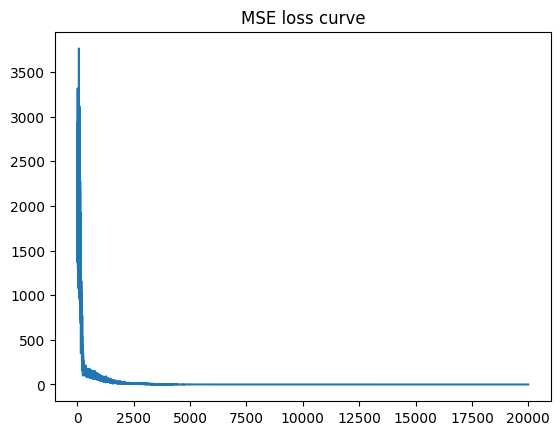

In [35]:
train_params = {
    'epoch_num': 10,
    'iteration_num': 2000,
    'learning_rate': 1e-3,
    'weight_decay': 5e-4,
    'batch_size': 32,
    'device': "cpu"
}

my_network = NeuralNet(num_hidden_layer=2, dim_hidden_layer=8)

train_dataset = create_dataset(500, -10, 10)

my_trainer = NeuralNetTrainer(dataset=train_dataset, network_model=my_network, params=train_params)
my_trainer.run()

### Plot the approximation function

Here, we want to show how accurate the learned non-linear function is. Specifically, we create three datasets that you have to evaluate as follows:

1. One training dataset: it contains all the training data you use to train the model above. (500 samples);
2. One test dataset: it contains 100 test samples with x > 10;
3. One test dataset: it contains 100 test samples with x < -10.

Using the three dataset above, visualize the prediction value as well the ground truth value for all samples in one dataset. Use the "plot_learned_function" in the "NeuralNetTrainer" class above. 

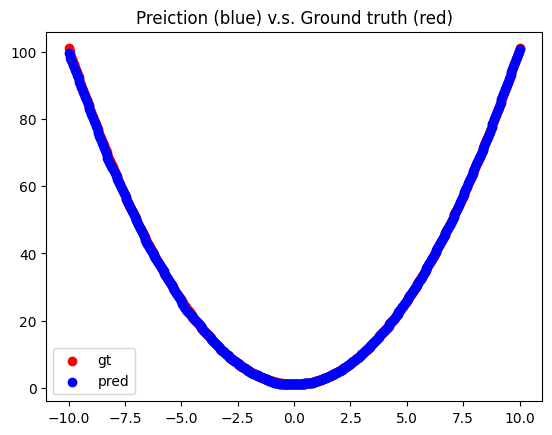

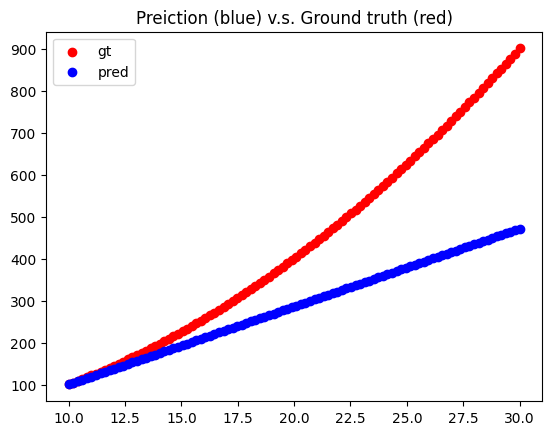

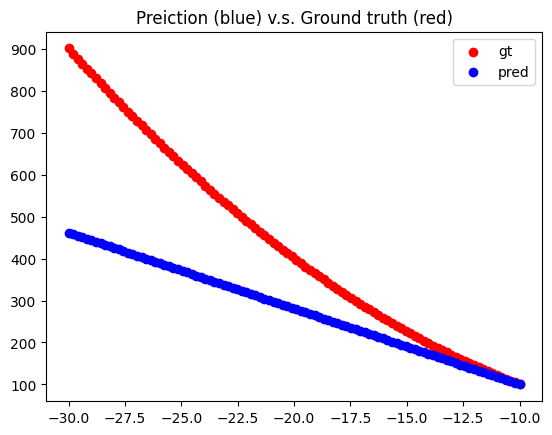

In [36]:
# training dataset to evaluate
train_dataset = create_dataset(500, -10, 10)

# test set 1: one test dataset contains samples with 10 < x < 30
upper_test_dataset = create_dataset(100, 10, 30)

# test set 2: one test dataset contains samples with -30 < x < -10
lower_test_dataset = create_dataset(100, -30, -10)

# Plot your results for all samples in the training set
my_trainer.plot_learned_function(train_dataset)

# Plot your results for all samples in test set 1
my_trainer.plot_learned_function(upper_test_dataset)

# Plot your results for all samples in test set 2
my_trainer.plot_learned_function(lower_test_dataset)

# Q2: DQN with Four Rooms

Here, let's write a DQN agent to resolve the FourRooms problem in this question. 

In [23]:
""" Here is the implementation of the FourRooms
    Note that, the reward function is changed to be:
        - If the agent reaches the goal, it receives 0 and the episode terminates.
        - For other time step, the agent receives -1 reward.
"""
class FourRooms(object):
    def __init__(self):
        # We define the grid for the Four Rooms domain
        self.grid = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

        # We define the observation space consisting of all empty cells
        # Note: We have to flip the coordinates from (row_idx, column_idx) -> (x, y),
        # where x = column_idx, y = 10 - row_idx
        self.observation_space = np.argwhere(self.grid == 0.0).tolist()  # Fine all empty cells
        self.observation_space = self.arr_coords_to_four_room_coords(self.observation_space)

        # We define the action space
        self.action_space = {'up': np.array([0, 1]),
                             'down': np.array([0, -1]),
                             'left': np.array([-1, 0]),
                             'right': np.array([1, 0])}
        self.action_names = ['up', 'down', 'left', 'right']

        # We define the start location
        self.start_location = [0, 0]

        # We define the goal location
        self.goal_location = [10, 10]

        # We find all wall cells
        self.walls = np.argwhere(self.grid == 1.0).tolist()  # find all wall cells
        self.walls = self.arr_coords_to_four_room_coords(self.walls)  # convert to Four Rooms coordinates

        # This is an episodic task, we define a timeout: maximal time steps = 459
        self.max_time_steps = 459

        # We define other useful variables
        self.agent_location = None  # track the agent's location in one episode.
        self.action = None  # track the agent's action
        self.t = 0  # track the current time step in one episode

    @staticmethod
    def arr_coords_to_four_room_coords(arr_coords_list):
        """
        Function converts the array coordinates to the Four Rooms coordinates (i.e, The origin locates at bottom left).
        E.g., The coordinates (0, 0) in the numpy array is mapped to (0, 10) in the Four Rooms coordinates.
        Args:
            arr_coords_list (list): a list variable consists of tuples of locations in the numpy array

        Return:
            four_room_coords_list (list): a list variable consists of tuples of converted locations in the
                                          Four Rooms environment.
        """
        # Note: We have to flip the coordinates from (row_idx, column_idx) -> (x, y),
        # where x = column_idx, y = 10 - row_idx
        four_room_coords_list = [(column_idx, 10 - row_idx) for (row_idx, column_idx) in arr_coords_list]
        return four_room_coords_list

    def reset(self):
        # We reset the agent's location to the start location
        self.agent_location = self.start_location

        # We reset the timeout tracker to be 0
        self.t = 0

        # We set the information
        info = {}
        return self.agent_location, info

    def step(self, action):
        """
        Args:
            action (string): a string variable (i.e., "UP"). All feasible values are ["up", "down", "left", "right"].
        """
        # With probability 0.8, the agent takes the correct direction.
        # With probability 0.2, the agent takes one of the two perpendicular actions.
        # For example, if the correct action is "LEFT", then
        #     - With probability 0.8, the agent takes action "LEFT";
        #     - With probability 0.1, the agent takes action "UP";
        #     - With probability 0.1, the agent takes action "DOWN".
        if np.random.uniform() < 0.2:
            if action == "left" or action == "right":
                action = np.random.choice(["up", "down"], 1)[0]
            else:
                action = np.random.choice(["right", "left"], 1)[0]

        # Convert the agent's location to array
        loc_arr = np.array(self.agent_location)

        # Convert the action name to movement array
        act_arr = self.action_space[action]

        # Compute the agent's next location
        next_agent_location = np.clip(loc_arr + act_arr,
                                      a_min=np.array([0, 0]),
                                      a_max=np.array([10, 10])).tolist()

        # Check if the agent crashes into walls, it stays at the current location.
        if tuple(next_agent_location) in self.walls:
            next_agent_location = self.agent_location

        """Note that, the reward function is changed as follows.
        """
        # Compute the reward
        reward = 0.0 if next_agent_location == self.goal_location else -1.0

        # Check the termination
        # If the agent reaches the goal, reward = 0, done = True
        # If the time steps reaches the maximal number, reward = -1, done = True.
        if reward == 0.0 or self.t == self.max_time_steps:
            terminated = True
        else:
            terminated = False

        # Update the agent's location, action and time step trackers
        self.agent_location = next_agent_location
        self.action = action
        self.t += 1

        return next_agent_location, reward, terminated, False, {}

    def render(self):
        # plot the agent and the goal
        # empty cell = 0
        # wall cell = 1
        # agent cell = 2
        # goal cell = 3
        plot_arr = self.grid.copy()
        plot_arr[10 - self.agent_location[1], self.agent_location[0]] = 2
        plot_arr[10 - self.goal_location[1], self.goal_location[0]] = 3
        plt.clf()
        plt.title(f"state={self.agent_location}, act={self.action}")
        plt.imshow(plot_arr)
        plt.show(block=False)
        plt.pause(0.1)

    @staticmethod
    def test():
        my_env = FourRooms()
        state, _ = my_env.reset()

        for _ in range(100):
            action = np.random.choice(list(my_env.action_space.keys()), 1)[0]

            next_state, reward, done, _, _ = my_env.step(action)
            my_env.render()

            if done:
                state, _ = my_env.reset()
            else:
                state = next_state

## Define a Deep Q network

Before, we write a DQN agent. Let's define a Deep Q network as we did in Q1. Otherwise, you could also adapt your
implementation above.

In [24]:
# customized weight initialization
def customized_weights_init(m):
    # compute the gain
    gain = nn.init.calculate_gain('relu')
    # init the convolutional layer
    if isinstance(m, nn.Conv2d):
        # init the params using uniform
        nn.init.xavier_uniform_(m.weight, gain=gain)
        nn.init.constant_(m.bias, 0)
    # init the linear layer
    if isinstance(m, nn.Linear):
        # init the params using uniform
        nn.init.xavier_uniform_(m.weight, gain=gain)
        nn.init.constant_(m.bias, 0)

In [25]:
class DeepQNet(nn.Module):
    def __init__(self, input_dim, num_hidden_layer, dim_hidden_layer, output_dim):
        super(DeepQNet, self).__init__()

        """CODE HERE: construct your Deep neural network
        """

    def forward(self, x):
        """CODE HERE: implement your forward propagation
        """
        return y

## Define a Experience Replay Buffer

One main contribution of DQN is proposing to use the replay buffer. Here is the implementation of a simple replay buffer as a list of transitions (i.e., [(s, a, r, s', d), ....]). 

In [26]:
class ReplayBuffer(object):
    """ Implement the Replay Buffer as a class, which contains:
            - self._data_buffer (list): a list variable to store all transition tuples.
            - add: a function to add new transition tuple into the buffer
            - sample_batch: a function to sample a batch training data from the Replay Buffer
    """
    def __init__(self, buffer_size):
        """Args:
               buffer_size (int): size of the replay buffer
        """
        # total size of the replay buffer
        self.total_size = buffer_size

        # create a list to store the transitions
        self._data_buffer = []
        self._next_idx = 0

    def __len__(self):
        return len(self._data_buffer)

    def add(self, obs, act, reward, next_obs, done):
        # create a tuple
        trans = (obs, act, reward, next_obs, done)

        # interesting implementation
        if self._next_idx >= len(self._data_buffer):
            self._data_buffer.append(trans)
        else:
            self._data_buffer[self._next_idx] = trans

        # increase the index
        self._next_idx = (self._next_idx + 1) % self.total_size

    def _encode_sample(self, indices):
        """ Function to fetch the state, action, reward, next state, and done arrays.
        
            Args:
                indices (list): list contains the index of all sampled transition tuples.
        """
        # lists for transitions
        obs_list, actions_list, rewards_list, next_obs_list, dones_list = [], [], [], [], []

        # collect the data
        for idx in indices:
            # get the single transition
            data = self._data_buffer[idx]
            obs, act, reward, next_obs, d = data
            # store to the list
            obs_list.append(np.array(obs, copy=False))
            actions_list.append(np.array(act, copy=False))
            rewards_list.append(np.array(reward, copy=False))
            next_obs_list.append(np.array(next_obs, copy=False))
            dones_list.append(np.array(d, copy=False))
        # return the sampled batch data as numpy arrays
        return np.array(obs_list), np.array(actions_list), np.array(rewards_list), np.array(next_obs_list), np.array(
            dones_list)

    def sample_batch(self, batch_size):
        """ Args:
                batch_size (int): size of the sampled batch data.
        """
        # sample indices with replaced
        indices = [np.random.randint(0, len(self._data_buffer)) for _ in range(batch_size)]
        return self._encode_sample(indices)

## Define a shedule for epsilon-greedy policy

Here, we define a shedule function to return the epsilon for each time step t. 

In [27]:
class LinearSchedule(object):
    """ This schedule returns the value linearly"""
    def __init__(self, start_value, end_value, duration):
        # start value
        self._start_value = start_value
        # end value
        self._end_value = end_value
        # time steps that value changes from the start value to the end value
        self._duration = duration
        # difference between the start value and the end value
        self._schedule_amount = end_value - start_value

    def get_value(self, time):
        # logic: if time > duration, use the end value, else use the scheduled value
        return self._start_value + self._schedule_amount * min(1.0, time * 1.0 / self._duration)

## Define the DQN agent

In [28]:
class DQNAgent(object):
    # initialize the agent
    def __init__(self,
                 params,
                 ):
        # save the parameters
        self.params = params

        # environment parameters
        self.action_dim = params['action_dim']
        self.obs_dim = params['observation_dim']

        # executable actions
        self.action_space = params['action_space']

        # create value network
        self.behavior_policy_net = DeepQNet(input_dim=params['observation_dim'],
                                   num_hidden_layer=params['hidden_layer_num'],
                                   dim_hidden_layer=params['hidden_layer_dim'],
                                   output_dim=params['action_dim'])
        # create target network
        self.target_policy_net = DeepQNet(input_dim=params['observation_dim'],
                                          num_hidden_layer=params['hidden_layer_num'],
                                          dim_hidden_layer=params['hidden_layer_dim'],
                                          output_dim=params['action_dim'])

        # initialize target network with behavior network
        self.behavior_policy_net.apply(customized_weights_init)
        self.target_policy_net.load_state_dict(self.behavior_policy_net.state_dict())

        # send the agent to a specific device: cpu or gpu
        self.device = torch.device("cpu")
        self.behavior_policy_net.to(self.device)
        self.target_policy_net.to(self.device)

        # optimizer
        self.optimizer = torch.optim.Adam(self.behavior_policy_net.parameters(), lr=params['learning_rate'])

    # get action
    def get_action(self, obs, eps):
        if np.random.random() < eps:  # with probability eps, the agent selects a random action
            action = np.random.choice(self.action_space, 1)[0]
            return action
        else:  # with probability 1 - eps, the agent selects a greedy policy
            obs = self._arr_to_tensor(obs).view(1, -1)
            with torch.no_grad():
                q_values = self.behavior_policy_net(obs)
                action = q_values.max(dim=1)[1].item()
            return self.action_space[int(action)]

    # update behavior policy
    def update_behavior_policy(self, batch_data):
        # convert batch data to tensor and put them on device
        batch_data_tensor = self._batch_to_tensor(batch_data)

        # get the transition data
        obs_tensor = batch_data_tensor['obs']
        actions_tensor = batch_data_tensor['action']
        next_obs_tensor = batch_data_tensor['next_obs']
        rewards_tensor = batch_data_tensor['reward']
        dones_tensor = batch_data_tensor['done']

        """CODE HERE:
                Compute the predicted Q values using the behavior policy network
        """
        # compute the q value estimation using the behavior network

        # compute the TD target using the target network

        # compute the loss

        # minimize the loss
        self.optimizer.zero_grad()
        td_loss.backward()
        self.optimizer.step()

        return td_loss.item()

    # update update target policy
    def update_target_policy(self):
        # hard update
        """CODE HERE: 
                Copy the behavior policy network to the target network
        """

    # auxiliary functions
    def _arr_to_tensor(self, arr):
        arr = np.array(arr)
        arr_tensor = torch.from_numpy(arr).float().to(self.device)
        return arr_tensor

    def _batch_to_tensor(self, batch_data):
        # store the tensor
        batch_data_tensor = {'obs': [], 'action': [], 'reward': [], 'next_obs': [], 'done': []}
        # get the numpy arrays
        obs_arr, action_arr, reward_arr, next_obs_arr, done_arr = batch_data
        # convert to tensors
        batch_data_tensor['obs'] = torch.tensor(obs_arr, dtype=torch.float32).to(self.device)
        batch_data_tensor['action'] = torch.tensor(action_arr).long().view(-1, 1).to(self.device)
        batch_data_tensor['reward'] = torch.tensor(reward_arr, dtype=torch.float32).view(-1, 1).to(self.device)
        batch_data_tensor['next_obs'] = torch.tensor(next_obs_arr, dtype=torch.float32).to(self.device)
        batch_data_tensor['done'] = torch.tensor(done_arr, dtype=torch.float32).view(-1, 1).to(self.device)

        return batch_data_tensor

## Define the training process

In [29]:
def train_dqn_agent(env, params):
    # create the DQN agent
    my_agent = DQNAgent(params)

    # create the epsilon-greedy schedule
    my_schedule = LinearSchedule(start_value=params['epsilon_start_value'],
                                 end_value=params['epsilon_end_value'],
                                 duration=params['epsilon_duration'])

    # create the replay buffer
    replay_buffer = ReplayBuffer(params['replay_buffer_size'])

    # training variables
    episode_t = 0
    rewards = []
    train_returns = []
    train_loss = []
    loss = 0

    # reset the environment
    obs, _ = env.reset()

    # start training
    pbar = tqdm.trange(params['total_training_time_step'])
    last_best_return = 0
    for t in pbar:
        # scheduled epsilon at time step t
        eps_t = my_schedule.get_value(t)
        # get one epsilon-greedy action
        action = my_agent.get_action(obs, eps_t)

        # step in the environment
        next_obs, reward, done, _, _ = env.step(action)

        # add to the buffer
        replay_buffer.add(obs, env.action_names.index(action), reward, next_obs, done)
        rewards.append(reward)

        # check termination
        if done:
            # compute the return
            G = 0
            for r in reversed(rewards):
                G = r + params['gamma'] * G

            if G > last_best_return:
                torch.save(my_agent.behavior_policy_net.state_dict(), f"./{params['model_name']}")

            # store the return
            train_returns.append(G)
            episode_idx = len(train_returns)

            # print the information
            pbar.set_description(
                f"Ep={episode_idx} | "
                f"G={np.mean(train_returns[-10:]) if train_returns else 0:.2f} | "
                f"Eps={eps_t}"
            )

            # reset the environment
            episode_t, rewards = 0, []
            obs, _ = env.reset()
        else:
            # increment
            obs = next_obs
            episode_t += 1

        if t > params['start_training_step']:
            # update the behavior model
            if not np.mod(t, params['freq_update_behavior_policy']):
                """ CODE HERE:
                    Update the behavior policy network
                """

            # update the target model
            if not np.mod(t, params['freq_update_target_policy']):
                """ CODE HERE:
                    Update the behavior policy network
                """

    # save the results
    return train_returns, train_loss

## Run experiment

In [30]:
def plot_curves(arr_list, legend_list, color_list, ylabel, fig_title):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

        Note that, make sure the elements in the arr_list, legend_list and color_list are associated with each other correctly.
        Do not forget to change the ylabel for different plots.
    """
    # set the figure type
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    # ploth results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # compute the standard error
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # plot the mean
        h, = ax.plot(range(arr.shape[1]), arr.mean(axis=0), color=color, label=legend)
        # plot the confidence band
        arr_err *= 1.96
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3,
                        color=color)
        # save the plot handle
        h_list.append(h)

    # plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)

    plt.show()

In [31]:
if __name__ == '__main__':
    # set the random seed
    np.random.seed(1234)
    random.seed(1234)
    torch.manual_seed(1234)

    # create environment
    my_env = FourRooms()

    # create training parameters
    train_parameters = {
        'observation_dim': 2,
        'action_dim': 4,
        'action_space': my_env.action_names,
        'hidden_layer_num': 2,
        'hidden_layer_dim': 128,
        'gamma': 0.99,

        'total_training_time_step': 500_000,

        'epsilon_start_value': 1.0,
        'epsilon_end_value': 0.01,
        'epsilon_duration': 250_000,

        'replay_buffer_size': 50000,
        'start_training_step': 2000,
        'freq_update_behavior_policy': 4,
        'freq_update_target_policy': 2000,

        'batch_size': 32,
        'learning_rate': 1e-3,

        'model_name': "four_room.pt"
    }

    # create experiment
    train_returns, train_loss = train_dqn_agent(my_env, train_parameters)

ValueError: optimizer got an empty parameter list

In [ ]:
plot_curves([np.array([train_returns])], ['dqn'], ['r'], 'discounted return', 'discounted returns wrt episode')

In [ ]:
plot_curves([np.array([train_loss])], ['dqn'], ['r'], 'training loss', 'loss wrt training steps')

## Q3: DQN with Classic Controls

In this notebook, we will implement DQN and run it on four environments which have a continuous state-space and discrete action-space.

 * Cart Pole: Balance a pole on a moving cart (https://gymnasium.farama.org/environments/classic_control/cart_pole/)
 * Lunar Lander: Fly and land a spaceship in the landing spot (https://gymnasium.farama.org/environments/box2d/lunar_lander/)

*Note: If you are having trouble loading Lunar Lander due to Box2D/SWIG issues, please refer to the [Gymnasium documentation](https://www.gymlibrary.dev/content/installation/#box2d) or online for more information.* One way is if Box2D is not installed, you can install it by run `pip install swig` followed by `pip install "gymnasium[box2d]"` or `pip install box2d box2d-kengz
`

In [ ]:
# Envs for training (no rendering)
envs = {
    'cartpole': gym.make('CartPole-v1'),
    'lunarlander': gym.make('LunarLander-v3'),
}
# Envs for visualization
envs_vis = {
    'cartpole': gym.make('CartPole-v1', render_mode="human"),
    'lunarlander': gym.make('LunarLander-v3', render_mode="human"),
}

In [ ]:
def render(env, policy=None):
    """Graphically render an episode using the given policy

    :param env: Gymnasium environment
    :param policy: Function which maps state to action.  If None, the random
                   policy is used.
    """

    if policy is None:
        # Random policy
        def policy(state):
            return env.action_space.sample()

    # Basic gym loop
    state, info = env.reset()
    while True:
        action = policy(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            break
        state = next_state

In [ ]:
#  Jupyter UI

def button_callback(button):
    for b in buttons:
        b.disabled = True

    env = envs_vis[button.description]
    render(env)
    env.close()

    for b in buttons:
        b.disabled = False

buttons = []
for env_id in envs_vis.keys():
    button = widgets.Button(description=env_id)
    button.on_click(button_callback)
    buttons.append(button)

print('Click a button to run a random policy:')
widgets.HBox(buttons)

## Part (a): Exponential $\varepsilon$-greedy decay

Instead of using a fixed value of $\varepsilon$, it is common to anneal $\varepsilon$ over time according to a schedule (such that initially almost all actions are exploratory). DQN used a linear decay schedule, but there we will use exponential decay, defined as:
$$\varepsilon_t = a \exp (b t)$$
where $a$ and $b$ are the parameters of the schedule. Beyond a specified number of time steps, $\varepsilon$ will be kept fixed at a small constant value to maintain continual exploration.

The interface to the scheduler receives the initial value, the final value, and in how many steps to go from initial to final. Your task is to compute parameters `a` and `b` to make the scheduler work as expected.

In [ ]:
class ExponentialSchedule:
    def __init__(self, value_from, value_to, num_steps):
        """Exponential schedule from `value_from` to `value_to` in `num_steps` steps.

        $value(t) = a \exp (b t)$

        :param value_from: Initial value
        :param value_to: Final value
        :param num_steps: Number of steps for the exponential schedule
        """
        self.value_from = value_from
        self.value_to = value_to
        self.num_steps = num_steps

        # YOUR CODE HERE: Determine the `a` and `b` parameters such that the schedule is correct
        self.a = ...
        self.b = ...

    def value(self, step) -> float:
        """Return exponentially interpolated value between `value_from` and `value_to`interpolated value between.

        Returns {
            `value_from`, if step == 0 or less
            `value_to`, if step == num_steps - 1 or more
            the exponential interpolation between `value_from` and `value_to`, if 0 <= steps < num_steps
        }

        :param step: The step at which to compute the interpolation
        :rtype: Float. The interpolated value
        """

        # YOUR CODE HERE: Implement the schedule rule as described in the docstring,
        # using attributes `self.a` and `self.b`.
        value = ...
        
        return value


# DO NOT EDIT: Test code

def _test_schedule(schedule, step, value, ndigits=5):
    """Tests that the schedule returns the correct value."""
    v = schedule.value(step)
    if not round(v, ndigits) == round(value, ndigits):
        raise Exception(
            f'For step {step}, the scheduler returned {v} instead of {value}'
        )

_schedule = ExponentialSchedule(0.1, 0.2, 3)
_test_schedule(_schedule, -1, 0.1)
_test_schedule(_schedule, 0, 0.1)
_test_schedule(_schedule, 1, 0.141421356237309515)
_test_schedule(_schedule, 2, 0.2)
_test_schedule(_schedule, 3, 0.2)
del _schedule

_schedule = ExponentialSchedule(0.5, 0.1, 5)
_test_schedule(_schedule, -1, 0.5)
_test_schedule(_schedule, 0, 0.5)
_test_schedule(_schedule, 1, 0.33437015248821106)
_test_schedule(_schedule, 2, 0.22360679774997905)
_test_schedule(_schedule, 3, 0.14953487812212207)
_test_schedule(_schedule, 4, 0.1)
_test_schedule(_schedule, 5, 0.1)
del _schedule

## Part (b): Replay memory

Now we will implement the replay memory (also called the replay buffer), the data-structure where we store previous experiences so that we can re-sample and train on them.

In [ ]:
# Batch namedtuple, i.e. a class which contains the given attributes
Batch = namedtuple(
    'Batch', ('states', 'actions', 'rewards', 'next_states', 'dones')
)


class ReplayMemory:
    def __init__(self, max_size, state_size):
        """Replay memory implemented as a circular buffer.

        Experiences will be removed in a FIFO manner after reaching maximum
        buffer size.

        Args:
            - max_size: Maximum size of the buffer
            - state_size: Size of the state-space features for the environment
        """
        self.max_size = max_size
        self.state_size = state_size

        # Preallocating all the required memory, for speed concerns
        self.states = torch.empty((max_size, state_size))
        self.actions = torch.empty((max_size, 1), dtype=torch.long)
        self.rewards = torch.empty((max_size, 1))
        self.next_states = torch.empty((max_size, state_size))
        self.dones = torch.empty((max_size, 1), dtype=torch.bool)

        # Pointer to the current location in the circular buffer
        self.idx = 0
        # Indicates number of transitions currently stored in the buffer
        self.size = 0

    def add(self, state, action, reward, next_state, done):
        """Add a transition to the buffer.

        :param state: 1-D np.ndarray of state-features
        :param action: Integer action
        :param reward: Float reward
        :param next_state: 1-D np.ndarray of state-features
        :param done: Boolean value indicating the end of an episode
        """

        # YOUR CODE HERE: Store the input values into the appropriate
        # attributes, using the current buffer position `self.idx`

        ...
        
        # DO NOT EDIT
        # Circulate the pointer to the next position
        self.idx = (self.idx + 1) % self.max_size
        # Update the current buffer size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size) -> Batch:
        """Sample a batch of experiences.

        If the buffer contains less that `batch_size` transitions, sample all
        of them.

        :param batch_size: Number of transitions to sample
        :rtype: Batch
        """

        # YOUR CODE HERE: Randomly sample an appropriate number of
        # transitions *without replacement*. If the buffer contains less than
        # `batch_size` transitions, return all of them. The return type must
        # be a `Batch`.

        sample_indices = ...
        batch = Batch(...)

        return batch

    def populate(self, env, num_steps):
        """Populate this replay memory with `num_steps` from the random policy.

        :param env: Gymnasium environment
        :param num_steps: Number of steps to populate the replay memory
        """

        # YOUR CODE HERE: Run a random policy for `num_steps` time-steps and
        # populate the replay memory with the resulting transitions.
        # Hint: Use the self.add() method.

        ...

## Part (c): Q-network

In this section, we define the object that DQN learns -- the Q-value neural network.

We use the PyTorch framework to define this neural network. PyTorch is a numeric computation library akin to NumPy, which also features automatic differentiation. This means that the library automatically computes the gradients for many differentiable operations, something we will exploit to train our models without having to manually program the gradients' code.
*Caveats: Sometimes we have to pay explicit attention to whether the operations we are using are implemented by the library (most are), and there are a number of operations which do not play well with automatic differentiation (most notably, in-place assignments).*

If you are unfamiliar with PyTorch, this will be a great opportunity to learn the basics. The official tutorials are a good start:\
https://pytorch.org/tutorials

Do not worry about learning the advanced details; the basics are enough. If you can understand the following MNIST code example and are able to run it yourself to train an MNIST digit classifier, you should know more than enough PyTorch to complete the assignment).\
https://github.com/pytorch/examples/blob/main/mnist/main.py

This library is a tool, and as many tools you will have to learn how to use it well. Sometimes not using it well means that your program will crash.  Sometimes it means that your program will not crash but will not be computing the correct outputs. And sometimes it means that it will compute the correct things, but is less efficient than it could otherwise be. This library is very popular these days, and online resources abound, so take your time to learn the basics. If you are having problems, first try to debug it yourself, and also look up the errors you get online. You can also use Piazza and office hours to ask for help with problems.

In the next cell, we inherit from the base class `torch.nn.Module` to implement our Q-network, which takes state-vectors and returns the respective action-values. Recall that the Q-network outputs the Q-values of **all** actions in the given input state.

In [ ]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, *, num_layers=3, hidden_dim=256):
        """Deep Q-Network PyTorch model.

        Args:
            - state_dim: Dimensionality of states
            - action_dim: Dimensionality of actions
            - num_layers: Number of total linear layers
            - hidden_dim: Number of neurons in the hidden layers
        """

        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        # YOUR CODE HERE: Define the layers of your model such that
        # * there are `num_layers` nn.Linear modules / layers
        # * all activations except the last should be ReLU activations
        #   (this can be achieved either using a nn.ReLU() object or the nn.functional.relu() method)
        # * the last activation can either be missing, or you can use nn.Identity()
        # Hint: A regular Python list of layers is tempting, but PyTorch does not register
        # these parameters in its computation graph. See nn.ModuleList or nn.Sequential

        ...

    def forward(self, states) -> torch.Tensor:
        """Q function mapping from states to action-values.

        :param states: (*, S) torch.Tensor where * is any number of additional
                dimensions, and S is the dimensionality of state-space
        :rtype: (*, A) torch.Tensor where * is the same number of additional
                dimensions as the `states`, and A is the dimensionality of the
                action-space. This represents the Q values Q(s, .)
        """
        # YOUR CODE HERE: Use the defined layers and activations to compute
        # the action-values tensor associated with the input states.
        # Hint: Do not worry about the * arguments above (previous dims in tensor).
        # PyTorch functions typically handle those properly.

        ...
    
    # DO NOT EDIT: Utility methods for cloning and storing models.
    
    @classmethod
    def custom_load(cls, data):
        model = cls(*data['args'], **data['kwargs'])
        model.load_state_dict(data['state_dict'])
        return model

    def custom_dump(self):
        return {
            'args': (self.state_dim, self.action_dim),
            'kwargs': {
                'num_layers': self.num_layers,
                'hidden_dim': self.hidden_dim,
            },
            'state_dict': self.state_dict(),
        }


# DO NOT EDIT: Test code

def _test_dqn_forward(dqn_model, input_shape, output_shape):
    """Tests that the dqn returns the correctly shaped tensors."""
    inputs = torch.torch.randn((input_shape))
    outputs = dqn_model(inputs)

    if not isinstance(outputs, torch.FloatTensor):
        raise Exception(
            f'DQN.forward returned type {type(outputs)} instead of torch.Tensor'
        )

    if outputs.shape != output_shape:
        raise Exception(
            f'DQN.forward returned tensor with shape {outputs.shape} instead of {output_shape}'
        )

    if not outputs.requires_grad:
        raise Exception(
            f'DQN.forward returned tensor which does not require a gradient (but it should)'
        )

dqn_model = DQN(10, 4)
_test_dqn_forward(dqn_model, (64, 10), (64, 4))
_test_dqn_forward(dqn_model, (2, 3, 10), (2, 3, 4))
del dqn_model

dqn_model = DQN(64, 16)
_test_dqn_forward(dqn_model, (64, 64), (64, 16))
_test_dqn_forward(dqn_model, (2, 3, 64), (2, 3, 16))
del dqn_model

# Testing custom dump / load
dqn1 = DQN(10, 4, num_layers=10, hidden_dim=20)
dqn2 = DQN.custom_load(dqn1.custom_dump())
assert dqn2.state_dim == 10
assert dqn2.action_dim == 4
assert dqn2.num_layers == 10
assert dqn2.hidden_dim == 20

## Part (d): Single-batch update

Recall that the Q-network in DQN is trained periodically using batches of experiences sampled from the replay memory. The following function computes the loss on this batch (one-step TD errors, using the Q-network and the target network) and uses the optimizer to perform one step of gradient descent using the gradient of this loss with respect to the Q-network parameters (automatically, thanks to PyTorch!).

In [ ]:
def train_dqn_batch(optimizer, batch, dqn_model, dqn_target, gamma) -> float:
    """Perform a single batch-update step on the given DQN model.

    :param optimizer: nn.optim.Optimizer instance
    :param batch: Batch of experiences (class defined earlier)
    :param dqn_model: The DQN model to be trained
    :param dqn_target: The target DQN model, ~NOT~ to be trained
    :param gamma: The discount factor
    :rtype: Float. The scalar loss associated with this batch
    """
    # YOUR CODE HERE: Compute the values and target_values tensors using the
    # given models and the batch of data.
    # Recall that 'Batch' is a named tuple consisting of
    # ('states', 'actions', 'rewards', 'next_states', 'dones')
    # Hint: Remember that we should not pass gradients through the target network
    values = ...
    target_values = ...

    # DO NOT EDIT

    assert (
        values.shape == target_values.shape
    ), 'Shapes of values tensor and target_values tensor do not match.'

    # Testing that the values tensor requires a gradient,
    # and the target_values tensor does not
    assert values.requires_grad, 'values tensor requires gradients'
    assert (
        not target_values.requires_grad
    ), 'target_values tensor should not require gradients'

    # Computing the scalar MSE loss between computed values and the TD-target
    # DQN originally used Huber loss, which is less sensitive to outliers
    loss = F.mse_loss(values, target_values)

    optimizer.zero_grad()  # Reset all previous gradients
    loss.backward()  # Compute new gradients
    optimizer.step()  # Perform one gradient-descent step

    return loss.item()

## Part (e): DQN training loop

This is the main training loop for DQN. Please refer to Algorithm 1 in the DQN paper (reproduced in lecture slides).

In [ ]:
def train_dqn(
    env,
    num_steps,
    *,
    num_saves=5,
    replay_size,
    replay_prepopulate_steps=0,
    batch_size,
    exploration,
    gamma,
):
    """
    DQN algorithm.

    Compared to previous training procedures, we will train for a given number
    of time-steps rather than a given number of episodes. The number of
    time-steps will be in the range of millions, which still results in many
    episodes being executed.

    Args:
        - env: The Gymnasium environment
        - num_steps: Total number of steps to be used for training
        - num_saves: How many models to save to analyze the training progress
        - replay_size: Maximum size of the ReplayMemory
        - replay_prepopulate_steps: Number of steps with which to prepopulate
                                    the memory
        - batch_size: Number of experiences in a batch
        - exploration: An ExponentialSchedule
        - gamma: The discount factor

    Returns: (saved_models, returns)
        - saved_models: Dictionary whose values are trained DQN models
        - returns: Numpy array containing the return of each training episode
        - lengths: Numpy array containing the length of each training episode
        - losses: Numpy array containing the loss of each training batch
    """
    # Check that environment states are compatible with our DQN representation
    assert (
        isinstance(env.observation_space, gym.spaces.Box)
        and len(env.observation_space.shape) == 1
    )

    # Get the state_size from the environment
    state_size = env.observation_space.shape[0]

    # Initialize the DQN and DQN-target models
    dqn_model = DQN(state_size, env.action_space.n)
    dqn_target = DQN.custom_load(dqn_model.custom_dump())

    # Initialize the optimizer
    optimizer = torch.optim.Adam(dqn_model.parameters())

    # Initialize the replay memory and prepopulate it
    memory = ReplayMemory(replay_size, state_size)
    memory.populate(env, replay_prepopulate_steps)

    # Initialize lists to store returns, lengths, and losses
    rewards = []
    returns = []
    lengths = []
    losses = []

    # Initialize structures to store the models at different stages of training
    t_saves = np.linspace(0, num_steps, num_saves - 1, endpoint=False)
    saved_models = {}

    i_episode = 0  # Use this to indicate the index of the current episode
    t_episode = 0  # Use this to indicate the time-step inside current episode

    state, info = env.reset()  # Initialize state of first episode
    G=0

    # Iterate for a total of `num_steps` steps
    pbar = tqdm.trange(num_steps)
    for t_total in pbar:
        # Use t_total to indicate the time-step from the beginning of training

        # Save model
        if t_total in t_saves:
            model_name = f'{100 * t_total / num_steps:04.1f}'.replace('.', '_')
            saved_models[model_name] = copy.deepcopy(dqn_model)

        # YOUR CODE HERE:
        #  * sample an action from the DQN using epsilon-greedy
        #  * use the action to advance the environment by one step
        #  * store the transition into the replay memory

        ...
        
        # YOUR CODE HERE: Once every 4 steps,
        #  * sample a batch from the replay memory
        #  * perform a batch update (use the train_dqn_batch() method)
        
        ...

        # YOUR CODE HERE: Once every 10_000 steps,
        #  * update the target network (use the dqn_model.state_dict() and
        #    dqn_target.load_state_dict() methods)
        
        ...

        if done:
            # YOUR CODE HERE: Anything you need to do at the end of an episode,
            # e.g., compute return G, store returns/lengths,
            # reset variables, indices, lists, etc.

            ...

            pbar.set_description(
                f'Episode: {i_episode} | Steps: {t_episode + 1} | Return: {G:5.2f} | Epsilon: {eps:4.2f}'
            )

            ...
        else:
            # YOUR CODE HERE: Anything you need to do within an episode
            ...

    saved_models['100_0'] = copy.deepcopy(dqn_model)

    return (
        saved_models,
        np.array(returns),
        np.array(lengths),
        np.array(losses),
    )

## Part (f): Evaluation of DQN on the 4 environments

In the following section, run DQN on some/all of the 4 environments loaded in the beginning of this notebook (Cart Pole, Mountain Car, Acrobot, Lunar Lander).

Each trial (in each environment) is trained for 1.5 million steps, which takes substantially longer than previous assignments, estimated to be around 1-2 hours on a typical desktop/laptop CPU. Because of this, we only expect you to train for one trial in each environment. Additionally, it is fine to only evaluate a minimum of 2 out of the 4 environments, although we recommend trying all 4 (and/or multiple trials) if you are able to.

Since there is only one trial, we cannot obtain meaningful averages / confidence bands as in past assignments. Instead, we will just apply a moving average to smooth out the data in our graphs (you should plot both the raw data and the moving average).

Obviously, during development and debugging, you should set the number of training steps (and possibly other hyperparameters) to be much lower. However, please remember to restore the original values when you perform the final evaluation. Also, different environments train at different speeds -- be cognizant of this when choosing an environment to develop in (e.g., Mountain car is designed as a hard exploration problem). We recommending starting in Cart Pole because it is an easier problem and the environment runs faster. For reference, we can run this environment at ~650 steps/s = 40K steps/min, and it usually takes 2000-4000 episodes = ~100K steps (with the default exponential schedule) to see some initial signs of learning.

In [ ]:
def moving_average(data, *, window_size = 50):
    """Smooths 1-D data array using a moving average.

    Args:
        data: 1-D numpy.array
        window_size: Size of the smoothing window

    Returns:
        smooth_data: A 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

### Cart Pole

Test your implentation on the Cart Pole environment. Training will take much longer than in the previous homeworks, so this time you will not have to find good hyperparameters or train multiple runs. This cell should take about 1-2 hours to run. After training, run the last cell in this notebook to view the policies which were obtained at 0%, 25%, 50%, 75% and 100% of the training.

In [ ]:
env = envs['cartpole']
gamma = 0.99

# We train for many time-steps; as usual, you can decrease this during development / debugging,
# but make sure to restore it to 1_500_000 before submitting
num_steps = 1_500_000
num_saves = 5  # Save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.05, 1_000_000)

# This should take about 1-2 hours on a generic 4-core laptop
dqn_models, returns, lengths, losses = train_dqn(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
)

assert len(dqn_models) == num_saves
assert all(isinstance(value, DQN) for value in dqn_models.values())

# Saving computed models to disk, so that we can load and visualize them later
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models.items()}
torch.save(checkpoint, f'checkpoint_{env.spec.id}.pt')

#### Plot the returns, lengths, and losses obtained while running DQN on the Cart Pole environment.

Again, plot both the raw data and the moving average **in the same plot**

In [ ]:
plt.plot(returns)
plt.plot(moving_average(returns))
plt.show()
plt.plot(lengths)
plt.plot(moving_average(lengths))
plt.show()
plt.plot(losses)
plt.plot(moving_average(losses))
plt.show()

### Lunar Lander

Test your implentation on the Lunar Lander environment. Training will take much longer than in the previous homeworks, so this time you will not have to find good hyperparameters or train multiple runs. This cell should take about 1-2 hours to run. After training, run the last cell in this notebook to view the policies which were obtained at 0%, 25%, 50%, 75% and 100% of the training

In [ ]:
env = envs['lunarlander']
gamma = 0.99

# We train for many time-steps; as usual, you can decrease this during development / debugging,
# but make sure to restore it to 1_500_000 before submitting
num_steps = 1_500_000
num_saves = 5  # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 200_000
replay_prepopulate_steps = 50_000

batch_size = 64
exploration = ExponentialSchedule(1.0, 0.05, 1_000_000)

# This should take about 1-2 hours on a generic 4-core laptop
dqn_models, returns, lengths, losses = train_dqn(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
)

assert len(dqn_models) == num_saves
assert all(isinstance(value, DQN) for value in dqn_models.values())

# Saving computed models to disk, so that we can load and visualize them later
checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models.items()}
torch.save(checkpoint, f'checkpoint_{env.spec.id}.pt')

#### Plot the returns, lengths, and losses obtained while running DQN on the Lunar Lander environment.

Again, plot both the raw data and the moving average **in the same plot**, i.e., you should have 2 plots total. 

In [ ]:
plt.plot(returns)
plt.plot(moving_average(returns))
plt.show()
plt.plot(lengths)
plt.plot(moving_average(lengths))
plt.show()
plt.plot(losses)
plt.plot(moving_average(losses))
plt.show()

### Visualization of the trained policies

Run the cell below and push the buttons to view the progress of the policy trained using DQN.

In [ ]:
buttons_all = []
for key_env, env in envs_vis.items():
    try:
        checkpoint = torch.load(f'checkpoint_{env.spec.id}.pt')
    except FileNotFoundError:
        pass
    else:
        buttons = []
        for key, value in checkpoint.items():
            dqn = DQN.custom_load(value)
            
            def make_callback(env, dqn):
                def button_callback(button):
                    for b in buttons_all:
                        b.disabled = True
                        
                    render(env, lambda state: dqn(torch.tensor(state, dtype=torch.float)).argmax().item())
                    
                    for b in buttons_all:
                        b.disabled = False
                        
                return button_callback
                
            button = widgets.Button(description=f'{key.replace("_", ".")}%')
            button.on_click(make_callback(env, dqn))
            buttons.append(button)
        
        print(f'{key_env}:')
        display(widgets.HBox(buttons))
        buttons_all.extend(buttons)

### Analysis

For each environment that you trained in, describe the progress of the training in terms of the behavior of the agent at each of the 5 phases of training (i.e. 0%, 25%, 50%, 75%, 100%). Make sure you view each phase a few times so that you can see all sorts of variations.

Describe something for each phase. Start by describing the behavior at phase 0%, then, for each next phase, describe how it differs from the previous one, how it improves and/or how it becomes worse. At the final phase (100%), also describe the observed behavior in absolute terms, and whether it has achieved optimality.

*Note: You may need to restart the kernel after rendering some episodes. Do not manually close the Pygame window. Even if you restart the kernel, you do not need to re-train on the environments; the relevant Q-network parameters should be stored in the corresponding PyTorch checkpoint .pt file.*

#### Cart Pole

* 0%) YOUR ANSWER HERE.
* 25%) YOUR ANSWER HERE.
* 50%) YOUR ANSWER HERE.
* 75%) YOUR ANSWER HERE.
* 100%) YOUR ANSWER HERE.

#### Lunar Lander

* 0%) YOUR ANSWER HERE.
* 25%) YOUR ANSWER HERE.
* 50%) YOUR ANSWER HERE.
* 75%) YOUR ANSWER HERE.
* 100%) YOUR ANSWER HERE.

# Q4 Extra Credit, DQN with Atari.

In [ ]:
""" Implement your code here """